investigate the trend in lake area from other sources

In [1]:
import os
import rasterio as rio
import numpy as np
import shapely 
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as riox
import rasterio as rio
import xarray as xr
import netCDF4
from osgeo import gdal
import pandas as pd
from datetime import datetime
import dask.array

In [2]:
# define folder and file paths
folder_HMA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"HMA2")
folder_glaciers = os.path.join(folder_HMA, 'Glacier Products')
folder_datasets = os.path.join(folder_HMA, 'Datasets')
fp_rgi = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'AOI_full_rgi.shp')
fp_regions = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'subregion_boundaries.shp')
fp_dc = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'AOI_dc_rgi.shp')

In [3]:
# open the rgi gdf, regions gdf
rgi_gdf = gpd.read_file(fp_rgi).to_crs("ESRI:102025")
dc_gdf = gpd.read_file(fp_dc).to_crs("ESRI:102025")
regions_gdf = gpd.read_file(fp_regions).to_crs("ESRI:102025")

# add the o3region as a column to each rgi
regions_gdf = regions_gdf.rename({"id":"o3region"}, axis=1)
dc_gdf = dc_gdf.sjoin(regions_gdf[["o3region","geometry"]])
rgi_gdf = rgi_gdf.sjoin(regions_gdf[["o3region","geometry"]])

In [72]:
# calculate total debris-covered area in our aois (m2)
total_dc_area = np.nansum( [ g.area for g in dc_gdf['geometry']] )
print(total_dc_area)

2515578814.992195


### Chen et al 2021 Hi-MAG database

In [4]:
# open chen_2021 lake outlines
folder_chen = os.path.join(folder_datasets, 'lake inventories', 'chen_2021', 'Hi-MAG database')

chen_all = []

for y in np.arange(2008,2018):
    path_open = os.path.join(folder_chen, f'HMA_Glacial_lake_{y}.shp')
    gdf_y = gpd.read_file(path_open).to_crs("ESRI:102025")
    chen_all.append(gdf_y)

# mosaic into single gdf
chen_all_gdf = gpd.GeoDataFrame(pd.concat(chen_all))

In [9]:
# filter to include only geometries that intersect with our aois
print(len(chen_all_gdf))
chen_filter = chen_all_gdf.sjoin(dc_gdf[['geometry','rgi_id']]).copy()
print(len(chen_filter))
# chen_filter.head(2)

126900
1059


In [10]:
# for each polygon in chen_filter, clip to debris_cover extent
c=0
new_geoms = []
new_areas = []
for idx, row in chen_filter.iterrows():
    c+=1
    # if c>1: continue
    
    # grab this lake's geometry
    g = row['geometry']
    
    # get the debris cover that intersects it
    dc_intersect = dc_gdf[dc_gdf['geometry'].intersects(g)]
    
    # clip lake to this glacier extent
    new_g = shapely.intersection(g, shapely.union_all(dc_intersect['geometry']))
    
    # format new row to save
    new_geoms.append(new_g)
    new_areas.append(new_g.area)

chen_filter['geometry']=new_geoms
chen_filter['Area']=new_areas

Text(0.5, 1.0, 'Chen et al. 2021 database')

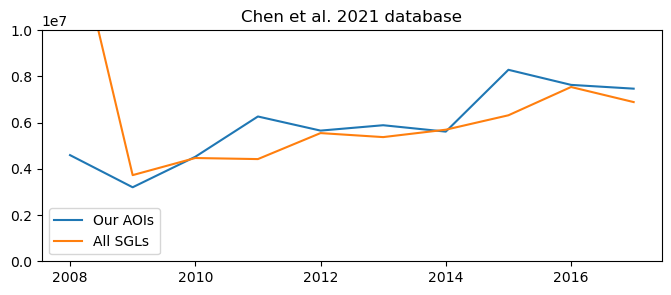

In [35]:
# aggregate total area by year
df_years_c1 = chen_filter[['year', 'Area']].groupby("year").sum(numeric_only=True).reset_index()

# plot. 
fig,axs = plt.subplots(figsize=(8,3))
axs.plot(df_years_c1['year'], df_years_c1['Area'], label='Our AOIs')

# also compare to what is classified in the database as SGLs
chen_all_sgl = chen_all_gdf[chen_all_gdf['Lake_type']=='SGL']
df_years_c2 = chen_all_sgl[['year', 'Area']].groupby("year").sum(numeric_only=True).reset_index()

axs.plot(df_years_c2['year'], df_years_c2['Area'], label='All SGLs')
axs.legend()
axs.set_ylim(0,1e7)
axs.set_title('Chen et al. 2021 database')

### Shugar et al 2020 database

In [26]:
# now lets look at shugar dataset
folder_shugar = os.path.join(folder_datasets, 'lake inventories', 'shugar_2020')

s1 = gpd.read_file(os.path.join(folder_shugar, f'HMA_15_18.shp'))
s2 = gpd.read_file(os.path.join(folder_shugar, f'HMA_10_14.shp'))
s3 = gpd.read_file(os.path.join(folder_shugar, f'HMA_05_09.shp'))
s4 = gpd.read_file(os.path.join(folder_shugar, f'HMA_00_04.shp'))
s5 = gpd.read_file(os.path.join(folder_shugar, f'HMA_90_99.shp'))

# mosaic into single gdf
shugar_all_gdf = gpd.GeoDataFrame(pd.concat([s1,s2,s3,s4,s5])).to_crs("ESRI:102025")


In [32]:
# filter to include only geometries that intersect with our aois
print(len(shugar_all_gdf))
shugar_filter = shugar_all_gdf.sjoin(dc_gdf[['geometry','rgi_id']]).copy()
print(len(shugar_filter))

# for each polygon in chen_filter, clip to debris_cover extent
c=0
new_geoms = []
new_areas = []
for idx, row in shugar_filter.iterrows():
    c+=1
    # if c>1: continue
    
    # grab this lake's geometry
    g = row['geometry']
    
    # get the debris cover that intersects it
    dc_intersect = dc_gdf[dc_gdf['geometry'].intersects(g)]
    
    # clip lake to this glacier extent
    new_g = shapely.intersection(g, shapely.union_all(dc_intersect['geometry']))
    
    # format new row to save
    new_geoms.append(new_g)
    new_areas.append(new_g.area)

shugar_filter['geometry']=new_geoms
shugar_filter['Area']=new_areas

Text(0.5, 1.0, 'Shugar et al. 2020 database')

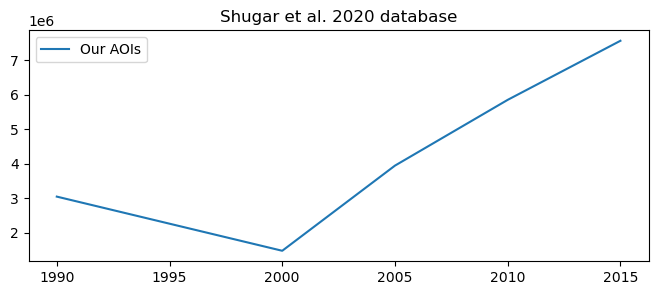

In [38]:
# aggregate total area by year and plot
df_years_s = shugar_filter[['Year_Start', 'Area']].groupby("Year_Start").sum(numeric_only=True).reset_index()
df_years_s['Year_Start'] = [ int(i) for i in df_years_s['Year_Start']]

fig,axs = plt.subplots(figsize=(8,3))
axs.plot(df_years_s['Year_Start'], df_years_s['Area'], label='Our AOIs')

axs.legend()
# axs.set_ylim(0,1e7)
axs.set_title('Shugar et al. 2020 database')

### Wang et al 2020 database

In [53]:
# now lets look at wang dataset
folder_wang = os.path.join(folder_datasets, 'lake inventories', 'wang_2020')

w1 = gpd.read_file(os.path.join(folder_wang, f'High_Asia_glacial_lake_1990.shp'))
w2 = gpd.read_file(os.path.join(folder_wang, f'High_Asia_glacial_lake_2018.shp'))
w1['year']=1990
w2['year']=2018

# mosaic into single gdf
wang_all_gdf = gpd.GeoDataFrame(pd.concat([w1,w2])).to_crs("ESRI:102025")

In [55]:
# filter to include only geometries that intersect with our aois
print(len(wang_all_gdf))
wang_filter = wang_all_gdf.sjoin(dc_gdf[['geometry','rgi_id']]).copy()
print(len(wang_filter))

# for each polygon in chen_filter, clip to debris_cover extent
c=0
new_geoms = []
new_areas = []
for idx, row in wang_filter.iterrows():
    c+=1
    # if c>1: continue
    
    # grab this lake's geometry
    g = row['geometry']
    
    # get the debris cover that intersects it
    dc_intersect = dc_gdf[dc_gdf['geometry'].intersects(g)]
    
    # clip lake to this glacier extent
    new_g = shapely.intersection(g, shapely.union_all(dc_intersect['geometry']))
    
    # format new row to save
    new_geoms.append(new_g)
    new_areas.append(new_g.area)

wang_filter['geometry']=new_geoms
wang_filter['Area']=new_areas

55042
517


Text(0.5, 1.0, 'Wang et al. 2020 database')

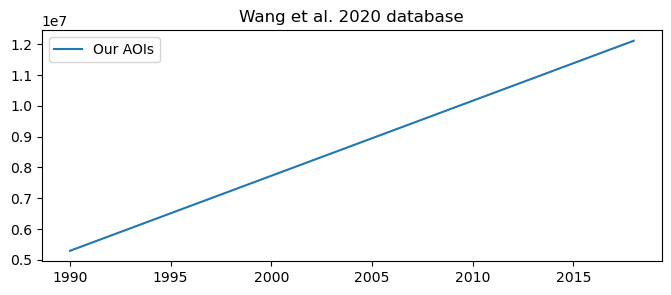

In [57]:
# aggregate total area by year and plot
df_years_w = wang_filter[['year', 'Area']].groupby("year").sum(numeric_only=True).reset_index()

fig,axs = plt.subplots(figsize=(8,3))
axs.plot(df_years_w['year'], df_years_w['Area'], label='Our AOIs')

axs.legend()
axs.set_title('Wang et al. 2020 database')

### Racoviteanu et al 2021 database

In [61]:
# now lets look at wang dataset
folder_rac = os.path.join(folder_datasets, 'lake inventories', 'racoviteanu_2021', 'shapefiles')

rac_all_gdf = gpd.read_file(os.path.join(folder_rac, f'Himalaya_L8_unmix_6cl_water_binary.shp')).to_crs("ESRI:102025")
rac_all_gdf['year']=2015

In [65]:
# filter to include only geometries that intersect with our aois
print(len(rac_all_gdf))
rac_filter = rac_all_gdf.sjoin(dc_gdf[['geometry','rgi_id']]).copy()
print(len(rac_filter))

# for each polygon in chen_filter, clip to debris_cover extent
c=0
new_geoms = []
new_areas = []
for idx, row in rac_filter.iterrows():
    c+=1
    # if c>1: continue
    
    # grab this lake's geometry
    g = row['geometry']
    
    # get the debris cover that intersects it
    dc_intersect = dc_gdf[dc_gdf['geometry'].intersects(g)]
    
    # clip lake to this glacier extent
    new_g = shapely.intersection(g, shapely.union_all(dc_intersect['geometry']))
    
    # format new row to save
    new_geoms.append(new_g)
    new_areas.append(new_g.area)

rac_filter['geometry']=new_geoms
rac_filter['Area']=new_areas
rac_area = np.nansum(rac_filter['Area'])
print("Total area:", rac_area)

20874
6392
Total area: 14310296.07435256


### Comparison of them all

Text(0, 0.5, 'SGL Area (m2)')

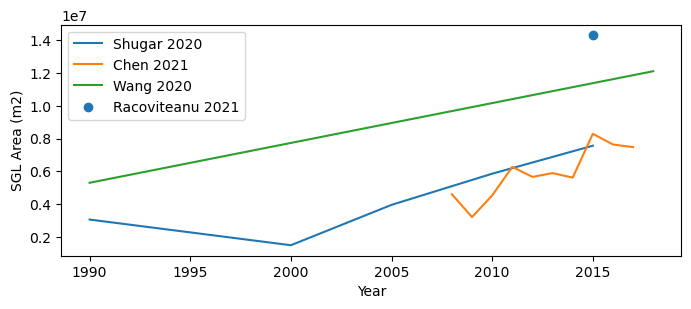

In [67]:
# plot total lake area in m2
fig,axs = plt.subplots(figsize=(8,3))

axs.plot(df_years_s['Year_Start'], df_years_s['Area'], label='Shugar 2020')
axs.plot(df_years_c1['year'], df_years_c1['Area'], label='Chen 2021')
axs.plot(df_years_w['year'], df_years_w['Area'], label='Wang 2020')
axs.scatter([2015],[rac_area], label = "Racoviteanu 2021")
    
axs.legend()

axs.set_xlabel("Year")
axs.set_ylabel("SGL Area (m2)")

Text(0, 0.5, 'SGL Area (%)')

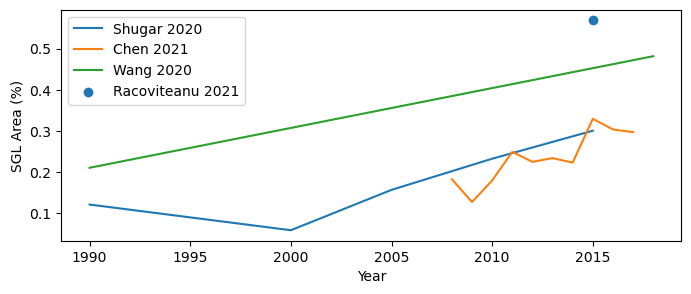

In [74]:
# plot as a percentage of debris cover
dc_area_m2 = total_dc_area

fig,axs = plt.subplots(figsize=(8,3))

axs.plot(df_years_s['Year_Start'], df_years_s['Area']/dc_area_m2*100, label='Shugar 2020')
axs.plot(df_years_c1['year'], df_years_c1['Area']/dc_area_m2*100, label='Chen 2021')
axs.plot(df_years_w['year'], df_years_w['Area']/dc_area_m2*100, label='Wang 2020')
axs.scatter([2015],[rac_area/dc_area_m2*100], label = "Racoviteanu 2021")
    
axs.legend()

axs.set_xlabel("Year")
axs.set_ylabel("SGL Area (%)")